In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

from src.utils.data_utils import TGIF
from src.utils.trainer import ModelTrainer

from src.models.vae import VAE, Initializer
from src.models.recurrent_network import RecurrentNetwork

import numpy as np
import os

%load_ext autoreload
%autoreload 2

TEST_MODEL_PATH = os.path.join(os.getcwd(), 'src', 'experiments', 'vae-natureframes')

In [2]:
def flatten(x):
    N = x.shape[0]
    return x.view(N, -1)

def lstm_flatten(x):
    B, T = x.shape[0], x.shape[1]
    return x.view(B, T, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [3]:
USE_GPU = True

dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using device:', device)
print('Using type:', dtype)

Using device: cuda
Using type: torch.float32


In [4]:
IMAGE_SZ = (64, 64)
BATCH_SZ = 512
NUM_WORKERS = 4
MAX_FRAMES = 10
DATASET_ROOT = '/home/deepdeepfakes/cs231n-project/src/datasets/GGIF/GIFs/nature'

gif_train_set = TGIF(
    root=f'{DATASET_ROOT}/train',
    preload=False,                    # careful: will load all into memory
    max_frames=MAX_FRAMES,
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SZ), # standardize size
        transforms.ToTensor(),       # conver to tensor between 0...1
                                     # TODO: subtract mean 
                                     # have fixed frame size somehow
    ]),
)

gif_val_set = TGIF(
    root=f'{DATASET_ROOT}/val',
    preload=False,                    # careful: will load all into memory
    max_frames=MAX_FRAMES,
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SZ), # standardize size
        transforms.ToTensor(),       # conver to tensor between 0...1
                                     # TODO: subtract mean 
                                     # have fixed frame size somehow
    ]),
)

gif_test_set = TGIF(
    root=f'{DATASET_ROOT}/test',
    preload=False,                    # careful: will load all into memory
    max_frames=MAX_FRAMES,
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SZ), # standardize size
        transforms.ToTensor(),       # conver to tensor between 0...1
                                     # TODO: subtract mean 
                                     # have fixed frame size somehow
    ]),
)

print(len(gif_train_set), len(gif_val_set), len(gif_test_set))

3995 750 250


In [5]:
gif_train_loader = DataLoader(gif_train_set, batch_size=BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
gif_val_loader = DataLoader(gif_val_set, batch_size=BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
gif_test_loader = DataLoader(gif_val_set, batch_size=BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)

In [6]:

DATASET_ROOT = '/home/deepdeepfakes/cs231n-project/src/datasets/GGIF/frames/nature'

TRANSFORMS = transforms.Compose([
    transforms.Resize(IMAGE_SZ),
    transforms.ToTensor(),
])

img_train_set = dset.ImageFolder(f'{DATASET_ROOT}/train', transform=TRANSFORMS)
img_val_set = dset.ImageFolder(f'{DATASET_ROOT}/test', transform=TRANSFORMS)
img_test_set = dset.ImageFolder(f'{DATASET_ROOT}/val', transform=TRANSFORMS)

print(len(img_train_set), len(img_val_set), len(img_test_set))

120138 7686 20916


In [7]:
img_train_loader = DataLoader(img_train_set, batch_size=BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
img_val_loader = DataLoader(img_val_set, batch_size=BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
img_test_loader = DataLoader(img_val_set, batch_size=BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def gif_show(gif):
    npimg = gif.numpy()
    out = np.transpose(npimg, (1, 2, 0))
    plt.imshow(out)
    
def img_show(img):
    plt.imshow(img)

torch.Size([40, 3, 64, 64])


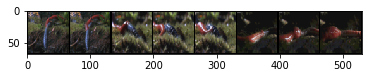

In [9]:
%matplotlib inline
gifs = []
for i, gif in enumerate(gif_train_loader):
    gifs.append(gif[0])
    if i == 3:
        break
gif = torch.cat(tuple(gifs), dim=0)
print (gif.shape)
gif_show(torchvision.utils.make_grid(gif[:8]))

torch.Size([512, 3, 64, 64])


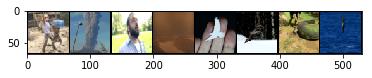

In [124]:
%matplotlib inline
img = iter(img_train_loader).next()[0]
print (img.shape)
gif_show(torchvision.utils.make_grid(img[:8]))

In [10]:
def train_fn(model, optimizer, inp):
    def loss_fn(recon_x, x, mu, logvar):
        mse_loss = nn.MSELoss(size_average=False)
        MSE = mse_loss(recon_x, x)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return MSE + KLD
        
    model.train()
    x = inp[0]
    x = x.to(device=device, dtype=dtype)
    recon_x, mu, logvar = model(x)

    loss = loss_fn(recon_x, x, mu, logvar)
    loss.cuda().backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

In [15]:
DISP_LIM = 8


def sample(model, seed_frame, gif_length=10):
    curr_h = model.init_hidden(BATCH_SZ)
    curr_x = seed_frame.to(device=device, dtype=dtype)
    model.eval()
    ret = [seed_frame]
    for i in range(gif_length - 1):
        y, curr_h = model(curr_x, curr_h)
        curr_x = y
        ret.append(y.to(device = torch.device('cpu')))
    return torch.stack(ret).transpose(0, 1)
    
def img_test_autoenc(model, loader):
    DISP_LIM = 8
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()
    x = x[0]
    print (x.shape)
    x = torch.tensor(x)
    x = x.to(device=device, dtype=dtype)
    y, mu, logvar = model(x)
    x = x.to(torch.device('cpu')).detach()
    y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
    imgs = torch.cat([x[:DISP_LIM], y[:DISP_LIM]])
    gif_show(torchvision.utils.make_grid(imgs))
    
def gif_test_autoenc(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()
    x = x[:, 0, :, :, :]
    x = x.to(device=device, dtype=dtype)
    y, mu, logvar = model(x)
    x = x.to(torch.device('cpu')).detach()
    y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
    imgs = torch.cat([x[:DISP_LIM], y[:DISP_LIM]])
    gif_show(torchvision.utils.make_grid(imgs))
    

In [21]:
NUM_CHANNELS = 3
INPUT_SIZE = IMAGE_SZ[0] * IMAGE_SZ[1] * NUM_CHANNELS   
HIDDEN_SIZE = INPUT_SIZE
OUTPUT_SIZE = INPUT_SIZE

net = VAE(latent_size=100, device=device)
Initializer.initialize(model=net, initialization=init.xavier_uniform_, gain=init.calculate_gain('relu'))
optimizer = optim.Adam(net.parameters(), lr=4e-4)
trainer = ModelTrainer(net, optimizer, train_fn, TEST_MODEL_PATH, save_models=False)

In [22]:
try:
#     optimizer = optim.Adam(net.parameters(), lr=1e-6)
#     trainer.update_optimizer(optimizer)
    print('Starting training...')
    trainer.train(img_train_loader, epochs=5, print_every=100, save_every=20)
except KeyboardInterrupt:
    print("Force saving")
    trainer.save_data(force_save=True)
print ('Done.')

Starting training...
Epoch [0] (0/234), loss = 10676128.0000
Epoch [0] (100/234), loss = 326141.5000
Epoch [0] (200/234), loss = 247499.6719
Epoch [0] done
Epoch [1] (0/234), loss = 236192.9062


Process Process-53:
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-55:
Process Process-56:
Process Process-54:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/site-packag

Force saving
Done.


  File "/home/shared/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/datasets/folder.py", line 101, in __getitem__
    sample = self.loader(path)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/datasets/folder.py", line 147, in default_loader
    return pil_loader(path)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/datasets/folder.py", line 147, in default_loader
    return pil_loader(path)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/datasets/folder.p

torch.Size([512, 3, 64, 64])
Evaluation mode: just returning mean


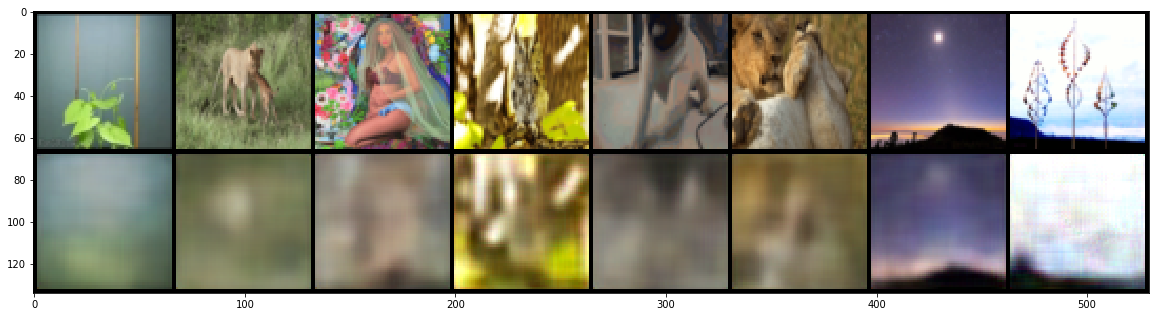

In [109]:
plt.figure(figsize=(20,40))
img_test_autoenc(net, img_train_loader)

Evaluation mode: just returning mean


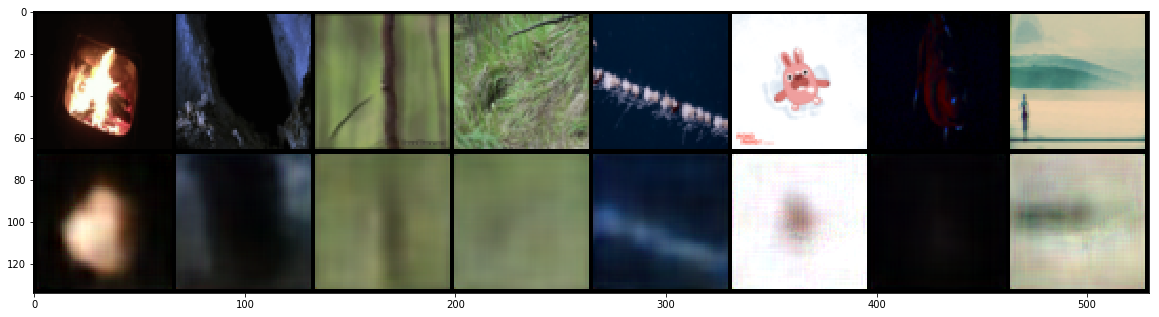

In [110]:
plt.figure(figsize=(20,40))
gif_test_autoenc(net, gif_val_loader)

In [114]:
trainer.save_data(force_save=True)